In [ ]:
#!pip install catboost

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
test = pd.read_csv('./data/test.csv')

In [3]:
df = pd.read_pickle('./data/data_1.pkl')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8032887 entries, 827691 to 8860577
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   month_id                    int8   
 1   shop_id                     int8   
 2   item_id                     int16  
 3   cnt_month                   float32
 4   city_id                     int8   
 5   cat_id                      int8   
 6   main_cat                    int8   
 7   sub_cat                     int8   
 8   year                        int16  
 9   month                       int8   
 10  sales_month                 int8   
 11  cnt_month_1                 float32
 12  cnt_month_2                 float32
 13  cnt_month_3                 float32
 14  item_id_mean_cnt_1          float32
 15  item_id_mean_cnt_2          float32
 16  item_id_mean_cnt_3          float32
 17  sub_cat_mean_cnt_1          float32
 18  sub_cat_mean_cnt_2          float32
 19  sub_cat_mean_cnt

In [5]:
df.head()

,month_id,shop_id,item_id,cnt_month,city_id,cat_id,main_cat,sub_cat,year,month,...,sub_cat_mean_cnt_3,price_mean_mean_cnt_1,price_mean_mean_cnt_2,price_mean_mean_cnt_3,item_id/city_id_mean_cnt_1,item_id/city_id_mean_cnt_2,item_id/city_id_mean_cnt_3,shop_id/cat_id_mean_cnt_1,shop_id/cat_id_mean_cnt_2,shop_id/cat_id_mean_cnt_3
827691,3,25,8092,3.0,13,40,11,6,2013,4,...,0.0,1.400024,1.365631,0.0,1.000000,2.142857,0.0,1.087262,1.048394,0.0
827692,3,25,7850,3.0,13,30,8,54,2013,4,...,0.0,1.479122,1.464680,0.0,3.714286,2.285714,0.0,3.651685,2.276650,0.0
827693,3,25,8051,3.0,13,66,14,47,2013,4,...,0.0,0.000000,0.000000,0.0,0.000000,0.428571,0.0,1.827586,1.389474,0.0
827694,3,25,8088,1.0,13,55,13,4,2013,4,...,0.0,1.479122,0.000000,0.0,0.285714,0.000000,0.0,0.598291,0.562107,0.0
827695,3,25,8089,1.0,13,55,13,4,2013,4,...,0.0,0.000000,0.000000,0.0,0.571429,0.000000,0.0,0.598291,0.562107,0.0


In [6]:
s = ['cnt_month', 'cnt_month_1','cnt_month_2', 'cnt_month_3', 'item_id_mean_cnt_1','item_id_mean_cnt_2', 'item_id_mean_cnt_3', 
        'sub_cat_mean_cnt_1','sub_cat_mean_cnt_2', 'sub_cat_mean_cnt_3', 'price_mean_mean_cnt_1',
       'price_mean_mean_cnt_2', 'price_mean_mean_cnt_3','item_id/city_id_mean_cnt_1', 'item_id/city_id_mean_cnt_2',
       'item_id/city_id_mean_cnt_3', 'shop_id/cat_id_mean_cnt_1','shop_id/cat_id_mean_cnt_2', 'shop_id/cat_id_mean_cnt_3']

In [8]:
# value clip(0~20)
df[s] = df[s].clip(0, 20)

In [9]:
# train/validation/test data split
X_train = df[df['month_id'] < 33].drop(['cnt_month'], axis=1)
Y_train = df[df['month_id'] < 33]['cnt_month']

X_valid = df[df['month_id'] == 33].drop(['cnt_month'], axis=1)
Y_valid = df[df['month_id'] == 33]['cnt_month']

X_test = df[df['month_id'] == 34].drop(['cnt_month'], axis=1)

### [CatBoost 란](https://dailyheumsi.tistory.com/136)

- 특징
    1. Level-wise로 트리 생성
    2. Ordered Boosting : 일부만 가지고 잔차계산 후 이를 기반한 모델을 만들고 그 뒤에 데이터의 잔차는 이 모델로 예측한 값을 사용
        * 과정
            data = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10]가 있다고 가정했을 때
            1. 먼저 x1의 잔차만 계산하고, 이를 기반으로 모델을 만들고 x2의 잔차를 이 모델로 예측
            2. x1, x2의 잔차를 가지고 모델을 만들고 이를 기반으로 x3,x4의 잔차를 모델로 예측
            3. x1, x2, x3, x4를 가지고 모델을 만들고 이를 기반으로 x5,x6,x7,x8의 잔차를 모델로 예측
            4. 반복
    3. Random Permutation : 오버피팅을 방지하고 트리를 다각적으로 만들기 위해 데이터를 셔플링하여 사용
    4. Ordered Target Encoding : 기존 Mean encoding 방법의 문제였던 예측값이 train set feature에 들어가는 Data Leakage에 대한 해결책으로 현재 데이터를 인코딩하기 위해 이전 데이터들의 인코딩된 값을 사용(자세한 방법은 위 링크에서 확인)
    5. Categorical Feature Combinations : imfomation gain이 동일한 두 feature를 하나의 feature로 만들어 데이터 전처리할 때 feature selection 부담이 줄어든다.
    6. One-hot Encoding : one_hot_max_size 파라미터 설정 가능. one_hot_max_size=3으로 설정한 경우 Cardeinality가 3이하인 범주형 변수들은 One-hot으로 인코딩
    7. Optimaized Parameter tuning : 기본 파라미터가 기본적을 최적화가 잘 되어있어 파라미터 튜닝에 크게 신경쓰지 않아도 된다.
    

- 한계
    * Sparse 한 Matrix 는 처리 불가
    * 데이터 대부분이 수치형 변수인 경우, Light GBM 보다 학습 속도가 느리다. (즉 대부분이 범주형 변수인 경우 사용)

In [11]:
cat = ['shop_id', 'item_id', 'city_id', 'cat_id', 'main_cat', 'sub_cat'] # 범주형 데이터 설정

In [15]:
ts = time.time()
model = CatBoostRegressor(
    max_depth=10,              # 트리의 최대 깊이
    n_estimators = 1000,       # 최대 트리 수
    eta = 0.3,                 # 학습률 : 증감률을 줄이는데 사용
    random_seed=123           # 훈련에 사용되는 랜덤 시드
    )

model.fit(
    X_train, Y_train, 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)],  # 유효성 검사 데이터 세트
    cat_features=[],                                    # 범주형 데이터 설정     
    verbose=True,                                      # True : 상세로그수준 / False : 자동로그수준 / int : 상세로그수준을 사용, 매개변수로 로깅기간 사용 
    early_stopping_rounds = 20                         # 검증횟수 설정
    )

print('소요시간: ',time.time()-ts)

0:	learn: 1.0963085	test: 1.0963085	test1: 0.9775945	best: 0.9775945 (0)	total: 2.89s	remaining: 48m 6s
1:	learn: 1.0178559	test: 1.0178559	test1: 0.9160379	best: 0.9160379 (1)	total: 5.85s	remaining: 48m 40s
2:	learn: 0.9733326	test: 0.9733326	test1: 0.8829131	best: 0.8829131 (2)	total: 9.14s	remaining: 50m 36s
3:	learn: 0.9471734	test: 0.9471734	test1: 0.8665139	best: 0.8665139 (3)	total: 12.3s	remaining: 50m 59s
4:	learn: 0.9316329	test: 0.9316329	test1: 0.8562593	best: 0.8562593 (4)	total: 15.5s	remaining: 51m 19s
5:	learn: 0.9215934	test: 0.9215934	test1: 0.8512985	best: 0.8512985 (5)	total: 18.6s	remaining: 51m 27s
6:	learn: 0.9119064	test: 0.9119064	test1: 0.8441888	best: 0.8441888 (6)	total: 22s	remaining: 52m 6s
7:	learn: 0.9059798	test: 0.9059798	test1: 0.8426068	best: 0.8426068 (7)	total: 25.3s	remaining: 52m 22s
8:	learn: 0.9014645	test: 0.9014645	test1: 0.8402786	best: 0.8402786 (8)	total: 28.7s	remaining: 52m 36s
9:	learn: 0.8959298	test: 0.8959298	test1: 0.8314805	best: 

In [16]:
Y_pred = model.predict(X_valid)

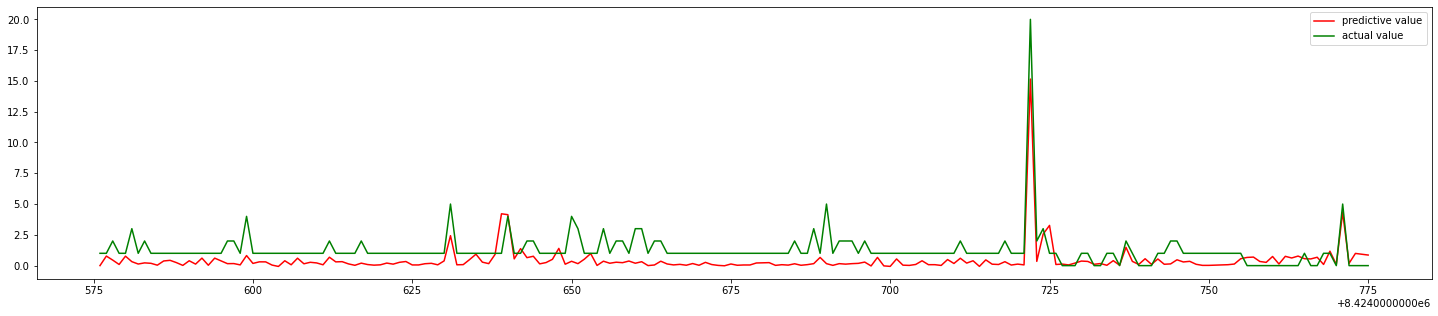

In [17]:
submission = pd.DataFrame({
    "ID": X_valid.index, 
    "item_cnt_month": Y_pred
})
x = submission['ID'].head(200)
y_pred = submission['item_cnt_month'].head(200)
y_true = Y_valid.head(200)
fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)
ax.plot(x, y_pred, label = 'predictive value', color = 'red')
ax.plot(x, y_true, label = 'actual value', color = 'green')

ax.legend()

plt.show()

In [18]:
Y_test = model.predict(X_test)

In [19]:
# 제출 파일 생성
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./submission/submission_CatBoost_2022022403.csv', index=False)